In [ ]:
from mcmc_integration_total import BayesCalibrationMCMC
#from mcmc_integration import BayesCalibrationMCMC
from metamodels import VPCEMetamodel, KarhunenLoeveMetamodel, GpMetamodelInd
import json
import numpy as np
import pickle
import csv
import openturns as ot
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from data_preparation  import preprocess_field_data

BASE_DIRECTORY = '/Users/edgarjaber/Desktop/Articles/codes folder/Bayes-calibration-for-clogging-prognostics/DATA/'
SIMULATION_TIME = np.load(BASE_DIRECTORY + 'simulation_data/LHS/d1/t_gv.npy', allow_pickle=True)

csv_file = BASE_DIRECTORY + 'field_data/field_data.csv'
input_dic = json.load(open(BASE_DIRECTORY + 'meta_data/SG_cleaning_conditioning.json'))
cleaning_dates = [input_dic['chemistry']['cleaning'][i]['time']/24 for i in range(len(input_dic['chemistry']['cleaning']))]

plt.rcParams['figure.dpi']= 300
plt.rcParams['text.usetex'] = True

In [ ]:
data, time_indices = preprocess_field_data(csv_file=csv_file, 
                                           operation_time=SIMULATION_TIME, 
                                           cleaning_dates=cleaning_dates,
                                           with_time_division=True)

with open(BASE_DIRECTORY +  '/metamodels/PCE/PCE_cal_5_07_mc.pkl', "rb") as f:
    unpickler = pickle.Unpickler(f)
    VPCE = unpickler.load()

with open(BASE_DIRECTORY +  '/metamodels/GP/gp_Quad_AbsExp_lhs.pkl', "rb") as f:
    unpickler = pickle.Unpickler(f)
    GP = unpickler.load()

with open(BASE_DIRECTORY +  '/metamodels/KL/KL_cal_Quad_mc.pkl', "rb") as f:
    unpickler = pickle.Unpickler(f)
    KL = unpickler.load()

with open(BASE_DIRECTORY +  '/metamodels/GP/gp_Quad_AbsExp_lhs_scaler.pkl', "rb") as f:
    unpickler = pickle.Unpickler(f)
    SCALER_GP = unpickler.load()

with open(BASE_DIRECTORY +  '/metamodels/KL/KL_scaler.pkl', "rb") as f:
    unpickler = pickle.Unpickler(f)
    SCALER_KL = unpickler.load()


Running Polynomial Chaos Expansion with regression method for degree 5, q-norm 0.7


WRN - set the component 58 of contributor 3=0 to zero as it is too small
WRN - set the component 4 of contributor 4=0 to zero as it is too small
WRN - set the component 62 of contributor 4=0 to zero as it is too small
WRN - set the component 79 of contributor 4=0 to zero as it is too small
WRN - set the component 80 of contributor 4=0 to zero as it is too small
WRN - set the component 48 of contributor 5=0 to zero as it is too small
WRN - set the component 89 of contributor 5=0 to zero as it is too small
WRN - Warning! For coherency we set scale upper bounds = [6.94659,6.88956]


In [3]:
step_size = 0.0005
proposal_distribution = ot.Uniform(-step_size, step_size)    

In [4]:
metamodels = [VPCE, GP, KL]
scalers = [None, SCALER_GP, SCALER_KL]

mcmc = BayesCalibrationMCMC(data=data[0], data_time_indices=time_indices[0], metamodels=metamodels, scalers=scalers)

NameError: name 'KL' is not defined

In [36]:
posterior_distributions_integrated = []
for i in range(len(data)):
    bayes_int = BayesCalibrationMCMC(data=data[i], data_time_indices=time_indices[i], metamodels=metamodels, scalers=scalers)
    posterior_distributions_integrated.append(bayes_int.mcmc_run(support_min=[0], support_max=[15e-4], proposal=proposal_distribution, burning=100, n_chains=5, sample_size=1000, nb_weights=1000))

Running Markov chain 0
Running Markov chain 1
Running Markov chain 2
Running Markov chain 3
Running Markov chain 4
Gelman-Rubin convergence diagnostic: 1.0001768511859155
Running Markov chain 0
Running Markov chain 1
Running Markov chain 2
Running Markov chain 3
Running Markov chain 4
Gelman-Rubin convergence diagnostic: 1.002062293352245
Running Markov chain 0
Running Markov chain 1
Running Markov chain 2
Running Markov chain 3
Running Markov chain 4
Gelman-Rubin convergence diagnostic: 0.999675225618033


In [37]:
n_sample = 10000
posterior_distrib_integrated_sample = np.asarray([np.asarray(posterior_distributions_integrated[i].getSample(n_sample)).reshape(-1) for i in range(len(posterior_distributions_integrated))])
posterior_distrib_df = pd.DataFrame(posterior_distrib_integrated_sample.T, columns=['CC', 'CC-PC', 'PC'])


In [38]:
prior = pd.DataFrame(np.asarray(ot.Uniform(0, 15e-4).getSample(n_sample)).reshape(-1), columns=['Prior'])

In [39]:
df_cc = pd.DataFrame({'Posterior': posterior_distrib_df['CC'], 'Prior': prior['Prior']})
df_cc_pc = pd.DataFrame({'Posterior': posterior_distrib_df['CC-PC'], 'Prior': prior['Prior']})
df_pc = pd.DataFrame({'Posterior': posterior_distrib_df['PC'], 'Prior': prior['Prior']})

Text(0.5, 1.0, 'PC')

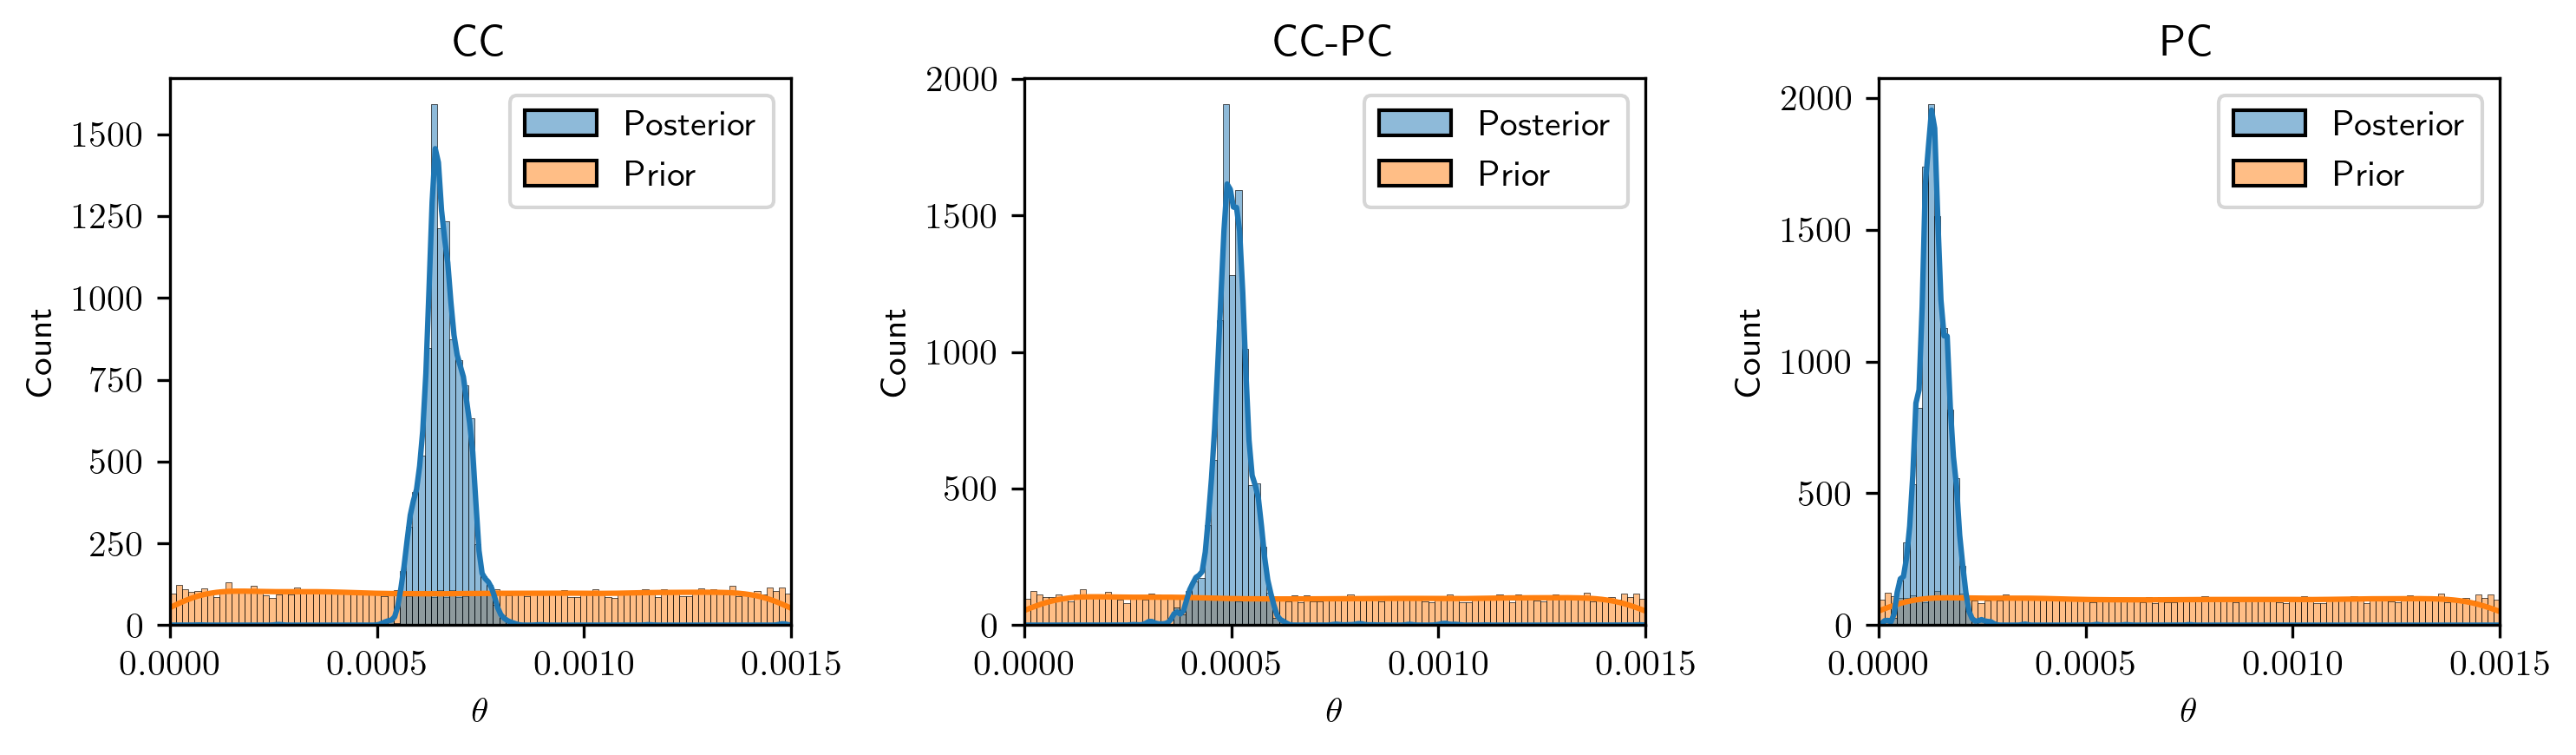

In [40]:
fig, axs = plt.subplots(1, 3, figsize=(10, 3), layout='tight')
sns.histplot(df_cc, kde=True, bins=100, common_norm=True, ax=axs[0])
sns.histplot(df_cc_pc, kde=True, bins=100, common_norm=True, ax=axs[1])
sns.histplot(df_pc, kde=True, bins=100, common_norm=True, ax=axs[2])
axs[0].set_xlim([0, 15e-4])
axs[1].set_xlim([0, 15e-4])
axs[2].set_xlim([0, 15e-4])

axs[0].set_xlabel(r'$\theta$')
axs[1].set_xlabel(r'$\theta$')
axs[2].set_xlabel(r'$\theta$')

axs[0].set_title('CC')
axs[1].set_title('CC-PC')
axs[2].set_title('PC')
